In [123]:
%matplotlib inline
import matplotlib.pylab as plt
import sys, os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter
from sklearn.preprocessing import scale
import bandicoot_dev as bc_d
from py_pcha.PCHA import PCHA
from sklearn import decomposition
from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd

import bandicoot_dev as bc_d

## Debugging

tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ]
}

def compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user


ds, user = compute_features(0)

w0_call = user.start_time['call'].date().isocalendar()[1]-1
w0_text = user.start_time['text'].date().isocalendar()[1]-1
w0_physical = user.start_time['physical'].date().isocalendar()[1]-1
w0_screen = user.start_time['screen'].date().isocalendar()[1]-1
w0_stop = user.start_time['stop'].date().isocalendar()[1]-1

wt_call = user.end_time['call'].date().isocalendar()[1]-1
wt_text = user.end_time['text'].date().isocalendar()[1]-1
wt_physical = user.end_time['physical'].date().isocalendar()[1]-1
wt_screen = user.end_time['screen'].date().isocalendar()[1]-1
wt_stop = user.end_time['stop'].date().isocalendar()[1]-1

print "call", w0_call, wt_call
print "text", w0_text, wt_text
print "physical", w0_physical, wt_physical
print "screen", w0_screen, wt_screen
print "stop", w0_stop, wt_stop

In [2]:
tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ],
    'weeks': range(53)
}
tc1 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "24/01/14"),
        ("03/02/14", "16/05/14"),
        ("01/09/14", "05/12/14"),
        ("02/06/14", "20/06/14")
    ],
    'weeks': range(1, 4) + \
             range(5, 16) + \
             range(17, 20) + \
             range(22, 25) + \
             range(35, 40) + \
             range(41, 49)
}
tc2 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("17/05/14", "01/06/14"),
        ("06/12/14", "21/12/14")
    ],
    'weeks': range(20, 22) + \
             range(49, 52)
}
tc3 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "05/01/14"),
        ("25/01/14", "02/02/14"),
        ("14/04/14", "20/04/14"),
        ("21/06/14", "30/08/14"),
        ("22/12/14", "31/12/14")
    ],
    'weeks': range(0, 1) + \
             range(4, 5) + \
             range(16, 17) + \
             range(25, 35) + \
             range(40, 41) + \
             range(52, 53)
}

In [64]:
def compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

def processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def get_periods(tc, groupby):
    """Only works for tc0!"""
    if groupby == "week":
        period = 7
    if groupby == "month":
        period = 30
    if groupby == "year":
        period = 365
    span = tc['spans'][0]
    delta = dt.strptime(span[1], "%d/%m/%y") - \
            dt.strptime(span[0], "%d/%m/%y")
    return int(np.ceil(delta.days/period)) + 1

def interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        try:
            X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
        except ValueError:
            X[mask_j,j] = 0
    return X

In [77]:
users = processed_users("tc0")
users_tmp = users
groupby = "month"
for l, u in enumerate(sorted(users_tmp)):
    print "\n", u
    
    ds, user = compute_features(u, groupby=groupby)
    
    # Initiate
    if l == 0:
        M = len(ds) + sum([1 for v in ds.values() if type(v[0]) is dict])  # Indicators
        N = get_periods(tc0, groupby)
        L = len(users_tmp)
        feat_names = []
        X = np.empty((N, M, L))

    U = np.full((N, M), None)
    
    c = 0
    for m, (f, vals) in enumerate(ds.items()):
        if l == 0:
            if type(vals[0]) is dict:
                feat_names.append(f + "_mean")
                feat_names.append(f + "_std")
            else:
                feat_names.append(f)

        for n, v in enumerate(vals):
            # v is either [int, int, int, ...], or [dict, dict, dict, ...]
            if type(v) is dict:
                U[n, m + c] = v['mean']
                U[n, m + c + 1] = v['std']
                increment_c = True
            else:
                U[n, m + c] = v
                increment_c = False
        
        if increment_c:
            c += 1

    X[:, :, l] = U


0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25
Grouping by month, but all data is from the same month!

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103
Grouping by month, but all data is from the same month!

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134
Grouping by month, but all data is from the same month!

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

177

178

179

180

181

182

183

184

185

186

187

188

189



In [82]:
# Interpolate nans!
for l in range(X.shape[2]):
    mask_i = ~np.all(np.isnan(X[:, :, l]) | np.equal(X[:, :, l], 0), axis=1)
    X[mask_i, :, l] = interpolate_nans(X[mask_i, :, l])

In [83]:
X_users_mean = np.nanmean(X[:, :, :],axis=0).T
X_users_mean = scale(X_users_mean[~np.isnan(X_users_mean).any(axis=1)])

# Save data
np.savetxt("data/X_users_mean.csv", X_users_mean, delimiter=",")

In [133]:
index_from = 0
zip(range(index_from, len(feat_names)+index_from),feat_names)

[(0, 'active_days__allweek__allday__screen'),
 (1, 'number_of_contacts__allweek__allday__text'),
 (2, 'number_of_contacts__allweek__allday__call'),
 (3, 'number_of_contacts__allweek__allday__physical'),
 (4, 'call_duration__allweek__allday__call_mean'),
 (5, 'call_duration__allweek__allday__call_std'),
 (6, 'percent_nocturnal__allweek__allday__text'),
 (7, 'percent_nocturnal__allweek__allday__call'),
 (8, 'percent_initiated_conversations__allweek__allday__call+text'),
 (9, 'percent_concluded_conversations__allweek__allday__text'),
 (10, 'percent_overlap_conversations__allweek__allday__text'),
 (11, 'percent_initiated_interactions__allweek__allday__call'),
 (12, 'response_delay_text__allweek__allday__call+text_mean'),
 (13, 'response_delay_text__allweek__allday__call+text_std'),
 (14, 'response_rate_text__allweek__allday__call+text'),
 (15, 'entropy_of_contacts__allweek__allday__text'),
 (16, 'entropy_of_contacts__allweek__allday__call'),
 (17, 'entropy_of_contacts__allweek__allday__phy

In [134]:
out_svm = Outlier_detector_svm(X_users_mean, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
#out_kd = Outlier_detector_kd(X_users_mean, visualize=True, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers = out_svm.main()

X_users_mean_clean = np.delete(X_users_mean,outliers,axis=0)

print "Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean.shape[0]-X_users_mean_clean.shape[0]), X_users_mean_clean.shape[0])

Removed 43 outliers, clean subset has 712 samples


### PCHA before PCA

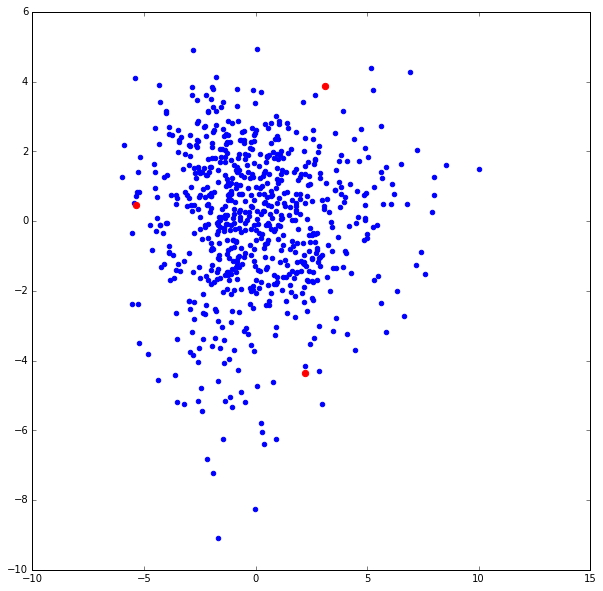

In [136]:
X0 = X_users_mean_clean.T
XC, S, C, SSE, varexpl = PCHA(X0, 3)

pca = decomposition.PCA(n_components=2)

pca.fit(X0.T)
X0 = pca.transform(X0.T).T

pca.fit(XC.T)
XC = pca.transform(XC.T).T

plt.figure(figsize=(10,10))
plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)
plt.show()

### PCA before PCHA

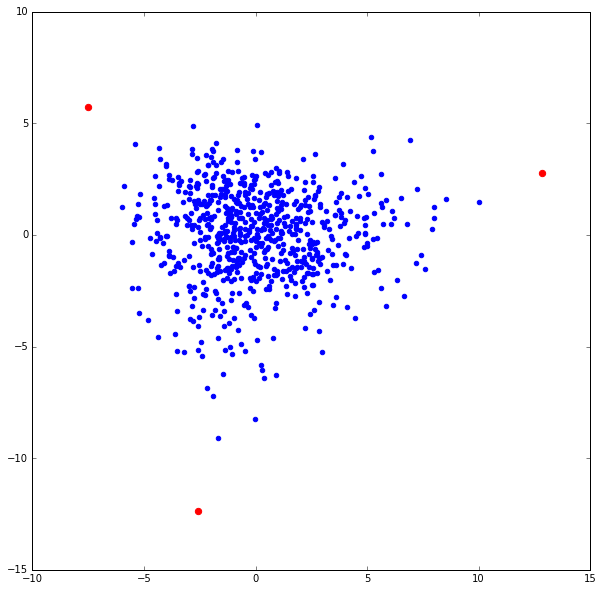

In [139]:
pca = decomposition.PCA(n_components=2)

X0 = X_users_mean_clean.T
pca.fit(X0.T)
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.figure(figsize=(10,10))
plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)
plt.show()

balance_of_contacts__allweek__allday__call_mean


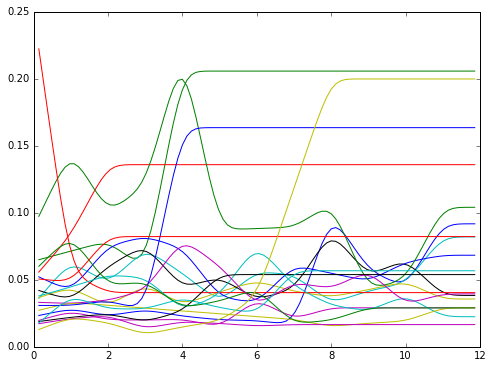

In [95]:
from scipy.ndimage import gaussian_filter1d
i = 20
print feat_names[i]
plt.figure(figsize=(8,6))
for l in range(X.shape[2]):
    y = X[:, i, l]
    x = range(len(y))
    t = np.linspace(0, 1, len(x))
    t2 = np.linspace(0, 1, 100)

    x2 = np.interp(t2, t, x)
    y2 = np.interp(t2, t, y)
    sigma = 2
    x3 = gaussian_filter1d(x2, sigma)
    y3 = gaussian_filter1d(y2, sigma)
    
    plt.plot(x3, y3)

In [102]:
df = pd.DataFrame(np.mean(X,axis=0).T)

In [ ]:
pd.scatter_matrix(df, alpha=0.2, figsize=(16, 16), diagonal='kde')